# Modelo de Predicción de Tasa de Cancelación de Cliente para Interconnect

# Introducción

Interconnect, un operador de telecomunicaciones, busca pronosticar la tasa de cancelación de clientes con el fin de implementar estrategias de retención basadas en promociones y planes especiales.

Se requiere desarrollar un modelo predictivo que, utilizando el comportamiento de clientes anteriores, permita identificar a aquellos que podrían decidir terminar su contrato con la compañía. Este es un caso de clasificación binaria.

El objetivo principal es predecir si un cliente cancelará su contrato, seleccionando el modelo con mejor rendimiento. La evaluación se realizará principalmente mediante la métrica AUC-ROC, complementada por la exactitud, para determinar qué tan preciso es el modelo.


### Inicialización

Para iniciar el desarrollo del análisis, comenzaremos importando las librerías que utilizaremos en la preparación de datos y la construcción del modelo.

Las principales librerías que se utilizarán son:

- **pandas**: permite la lectura y manipulación de datos en forma de tablas (DataFrames).
- **NumPy**: facilita operaciones numéricas y manejo de arreglos multidimensionales.
- **Seaborn**: se utilizará para visualizar y explorar patrones en los datos.
- **scikit-learn**: proporciona herramientas para crear y evaluar modelos de machine learning.

In [1]:
import warnings
# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression

## Carga de archivos

Procedemos con la carga de las bases de datos que nos proporcionan información de diferentes fuentes. A continuación se describen los archivos disponibles:

- `contract.csv`: información del contrato.
- `personal.csv`: datos personales del cliente.
- `internet.csv`: información sobre los servicios de Internet.
- `phone.csv`: información sobre los servicios telefónicos.

Para la carga de los datos, se utilizará la función `read_csv` de la librería pandas, indicando como argumento la ubicación de cada archivo.

Guardaremos los datos en variables con los siguientes nombres:
- `df_contract`
- `df_personal`
- `df_internet`
- `df_phone`

In [2]:
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

# Exploración inicial de los datos

Ahora que hemos cargado los datasets, es importante validar la información que contienen.

Examinaremos cada uno de ellos utilizando los siguientes métodos de pandas:
- `head`: para visualizar las primeras filas y tener una idea general de los datos.
- `shape`: para conocer la cantidad de filas y columnas.
- `info()`: para revisar los tipos de datos y la presencia de valores nulos.
- `describe()`: para obtener estadísticas básicas de las variables numéricas.

Este análisis preliminar nos permitirá identificar si es necesario realizar correcciones, limpieza o un tratamiento adicional de los datos antes de continuar con el preprocesamiento.
Una vez que todos los datasets estén limpios y preparados, se integrarán en un único dataset maestro que consolide la información de cada cliente.

### Exploración estructural y corrección de datos para el dataset de contratos.

In [3]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
df_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [6]:
df_contract.shape

(7043, 8)

#### Transformación y corrección de datos

Después de revisar la estructura de los datos con los métodos `shape`, `info()`, `head()` y `describe()`, se realizarán los siguientes pasos:

- Cambiar los nombres de las columnas a minúsculas para estandarizar, se creara la función column_snake_case.
- Corregir los tipos de datos en las columnas:
  - Columnas de fechas (`begindate` y `enddate`) al formato datetime.
  - Columna `totalcharges` a tipo numérico (float).
- Validar si existen valores nulos (`NA`) en las columnas.
- Verificar la presencia de registros duplicados.

**Observaciones preliminares:**
- El dataset contiene 8 columnas y 7043 registros.
- Según `info()`, no se observaron valores ausentes de forma evidente, pero se realizará una validación adicional para confirmar.
- Los valores numéricos presentan rangos coherentes en `monthlycharges`, aunque se debe revisar `totalcharges` por posibles inconsistencias en su formato.

In [7]:
#Creación de función y conversión de nombres de columnas a minisculas.

def column_snake_case(df):
    df.columns = (
        df.columns
        .str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True)
        .str.lower()
    )
    return df

column_snake_case(df_contract)
print(df_contract.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')


In [8]:
#Conversión de datatype de la columna 'begin_date' y 'end_date'
dates_col_contract = ['begin_date', 'end_date']
for columna in dates_col_contract:
    df_contract[columna] = pd.to_datetime(df_contract[columna], errors='coerce')

df_contract[['begin_date', 'end_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   begin_date  7043 non-null   datetime64[ns]
 1   end_date    1869 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 110.2 KB


In [9]:
#Coversión de 'total_charges' a tipo númerico.
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors='coerce')
df_contract[['total_charges']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_charges  7032 non-null   float64
dtypes: float64(1)
memory usage: 55.1 KB


In [10]:
#Validación de datos nulos (NA)
print(df_contract.isnull().sum())

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
dtype: int64


Observamos que existen 5174 valores nulos, sin embargo, son clientes activos. Más adelante esta columna se convertira en una columna binaria para identificar activos y bajas.

In [11]:
# Vamos a analizar los valores nulos en 'total_charges' para decidir cómo imputarlos.
df_contract[df_contract['total_charges'].isnull()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


Podemos observar que los datos nulos en la columna `total_charges` corresponden a clientes que recién comenzaron su contrato con la compañía, por lo que aún no tienen un importe facturado. Por este motivo, se imputarán con 0.

In [12]:
#Imputar valores NA con 0 en columna 'totalcharges'
df_contract['total_charges'] = df_contract['total_charges'].fillna(0)
df_contract['total_charges'].isnull().sum()

0

In [13]:
#Validación de duplicados
df_contract.duplicated().sum()

0

Ahora con los datos correctos analizaremos la información correcta con .describe()

In [14]:
df_contract.describe()

,monthly_charges,total_charges
count,7043.000000,7043.000000
mean,64.761692,2279.734304
std,30.090047,2266.794470
min,18.250000,0.000000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


Hallazgos de la exploración del dataset de contratos

Después de la limpieza y conversión de datos, se identificaron las siguientes características:

- No existen valores nulos en `monthly_charges` y `total_charges`.
- Se imputaron con 0 los registros recientes que no tenían cargos acumulados.
- Los rangos de `monthly_charges` y `total_charges` son coherentes con la operación de la compañía.
- La dispersión de `total_charges` es alta, lo que indica que hay clientes con distinta antigüedad y niveles de facturación.

Los datos quedaron listos para integrarse posteriormente con los demás datasets.

### Exploración estructural para el dataset de personal.

In [15]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [16]:
df_personal.shape

(7043, 5)

In [17]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [18]:
df_personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


#### Transformación y corrección de datos

En este dataset no será necesario cambiar los tipos de datos, ya que todos se encuentran correctamente definidos.

Se realizarán las siguientes acciones:
- Estandarizar los nombres de las columnas a formato `snake_case`.
- Verificar si existen valores ausentes o nulos en alguna columna y, en caso de encontrarlos, analizar la mejor forma de imputación.
- Revisar si existen registros duplicados.


In [19]:
#Conversión de nombres de columnas a minisculas.
column_snake_case(df_personal)
print(df_personal.columns)

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')


In [20]:
#Validación de datos nulos (NA)
print(df_personal.isnull().sum())

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64


In [21]:
#Validación de duplicados
df_personal.duplicated().sum()

0

Hallazgos de la exploración del dataset de datos personales

Después de la exploración de datos, se identificaron las siguientes características:

- El tipo de dato (`dtype`) de cada columna es correcto, por lo que no fue necesario realizar cambios.
- No se encontraron valores ausentes ni nulos.
- No hay registros duplicados.
- La información obtenida con `describe()` es coherente: el dataset contiene 7043 registros, y en la columna `senior_citizen` el valor mínimo es 0 y el máximo es 1, lo que confirma que ya es una variable binaria.

Este dataset está listo para integrarse al dataset maestro.


### Exploración estructural para el dataset de internet.

In [22]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [23]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [24]:
df_internet.shape

(5517, 8)

In [25]:
df_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,1024-GUALD,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


#### Transformación y corrección de datos.
Después de realizar la exploración inicial (`head()`, `info()`, `shape()` y `describe()`), se identificaron las siguientes características:

- Todas las columnas tienen el tipo de dato `object`, lo que es adecuado ya que representan variables categóricas.
- La mayoría de las columnas contienen valores "Yes" y "No", por lo que serán más fáciles de procesar con codificación one-hot en etapas posteriores.
- El dataset contiene 5,517 registros, un número menor al de los otros datasets revisados previamente, por lo que será necesario considerar este detalle al momento de hacer la unión final.
- La información obtenida con `describe()` muestra que las categorías son consistentes y no hay valores inesperados.

A continuación, se realizarán estas acciones:

- Estandarizar los nombres de las columnas a formato `snake_case`.
- Verificar si existen valores nulos o ausentes y definir la estrategia de imputación si es necesario.
- Revisar si hay registros duplicados.


In [26]:
#Conversión de nombres de columnas a minisculas.
column_snake_case(df_internet)
print(df_internet.columns)

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')


In [27]:
#Validación de datos nulos (NA)
print(df_internet.isnull().sum())

customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64


In [56]:
#Validación de duplicados
df_internet.duplicated().sum()

0

Hallazgos finales del dataset de servicios de Internet

Después de la exploración y limpieza del dataset, se identificaron las siguientes características complementarias:

- Todas las columnas tienen tipos de datos correctos y son variables categóricas.
- No se encontraron valores nulos, ausentes ni registros duplicados.
- Los nombres de las columnas fueron estandarizados al formato `snake_case`.

**Nota importante:** Este dataset contiene menos registros (5,517) que los otros datasets revisados anteriormente. Esto se debe a que no todos los clientes cuentan con servicios de Internet. Será necesario tener en cuenta este detalle al momento de realizar la unión final de los datos.

### Exploración estructural para el dataset de phone.

In [29]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [30]:
df_phone.shape

(6361, 2)

In [31]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [32]:
df_phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,3970-XGJDU,No
freq,1,3390


#### Transformación y corrección de datos.

Después de realizar la exploración inicial (`head()`, `info()`, `shape()` y `describe()`), se identificaron las siguientes características:

- Las columnas tienen tipos de datos correctos y no es necesario realizar cambios en este aspecto.
- El dataset contiene 6,361 registros, por lo que también tiene menos datos que los dos primeros datasets analizados.
- La columna `multiple_lines` es categórica con valores "Yes" y "No".

A continuación, se realizarán estas acciones:

- Estandarizar los nombres de las columnas al formato `snake_case`.
- Verificar si existen valores nulos o ausentes y definir la estrategia de imputación en caso necesario.
- Revisar si hay registros duplicados.

**Nota:** Será importante tener presente la diferencia en la cantidad de registros al momento de unir este dataset con los demás.


In [33]:
#Conversión de nombres de columnas a estructura snake_case.
column_snake_case(df_phone)
print(df_phone.columns)

Index(['customer_id', 'multiple_lines'], dtype='object')


In [34]:
#Validación de datos nulos (NA)
print(df_phone.isnull().sum())

customer_id       0
multiple_lines    0
dtype: int64


In [57]:
#Validación de duplicados
df_phone.duplicated().sum()

0

Hallazgos finales del dataset de servicios telefónicos

Después de la exploración y limpieza del dataset, se identificaron las siguientes características:

- No se encontraron valores nulos, ausentes ni registros duplicados.
- Los nombres de las columnas fueron estandarizados al formato `snake_case`.

**Nota importante:** Este dataset contiene menos registros (6,361) que algunos de los otros datasets revisados. Esto se debe a que no todos los clientes cuentan con servicios telefónicos, por lo que será necesario considerar este detalle al realizar la unión final de los datos.


# Unión de los datasets.

En este paso integraremos los cuatro datasets en un único DataFrame que consolide toda la información disponible sobre los clientes.

Para conservar todos los registros de clientes, se realizará una unión utilizando la tabla de contratos como base principal. Esto permite mantener a todos los clientes en el dataset final, incluso si algunos no cuentan con servicios de Internet o servicios telefónicos.

La unión se hará sobre la columna `customer_id`, que actúa como identificador único en los cuatro datasets. El método de unión elegido será el de tipo `left`, de modo que se conserven todos los registros de la tabla principal (`contract`) y se añadan los datos de las otras tablas donde haya coincidencias.

Después de la unión, se revisará si existen valores nulos resultantes y se definirá la estrategia para su imputación.


In [36]:
df_master = df_contract.merge(df_personal, on="customer_id", how="left")
df_master = df_master.merge(df_internet, on="customer_id", how="left")
df_master = df_master.merge(df_phone, on="customer_id", how="left")

In [37]:
df_master.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [38]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [39]:
#Validación de datos nulos (NA)
print(df_master.isnull().sum())

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64


#### Transformación y corrección de datos.

Después de unir los datasets, se identificaron valores nulos en las columnas relacionadas con los servicios de Internet y telefónicos. Estos valores corresponden a clientes que no tienen contratado alguno de estos servicios y, por lo tanto, no aparecen en los datasets originales de dichas categorías.

La estrategia de imputación será la siguiente:

- Para todas las columnas binarias relacionadas con los servicios de Internet y teléfono (por ejemplo, `online_security`, `online_backup`, `tech_support`, `multiple_lines`, etc.), se imputará el valor `"No"` indicando que el cliente no utiliza estos servicios.
- Para la columna `internet_service`, que contiene el nombre del tipo de servicio contratado, se imputará el valor `"Sin servicio"` para diferenciar claramente los casos donde no hay servicio de Internet.

De este modo, se estandarizarán los datos sin eliminar registros y se mantendrá la información coherente con la situación real de cada cliente.

In [40]:
#Creo una lista de las columnas sin servicio.
no_service = [
    "online_security",
    "online_backup",
    "device_protection",
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "multiple_lines"
]

In [41]:
#Creamos un bucle para imputar los valores ausentes con "No" para las columnas sin servicio que contienen datos de Si o No. 
for columna in no_service:
    df_master[columna] = df_master[columna].fillna("No")

In [42]:
#Imputamos valores de la columna 'internet_service' con "Sin servicio"
df_master['internet_service'].fillna('Sin Servicio', inplace=True)

In [43]:
df_master.isnull().sum()

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
multiple_lines          0
dtype: int64

## Distribución de cancelaciones a lo largo del tiempo

Antes de transformar la columna `end_date`, se realizará una visualización para explorar la distribución temporal de las cancelaciones de contrato.

El objetivo de esta gráfica es identificar posibles patrones en las fechas en las que los clientes han cancelado sus servicios, como concentraciones inusuales en determinados días o periodos. Este análisis puede aportar información valiosa sobre el comportamiento de cancelación, la estacionalidad o incluso eventos específicos que hayan influido en la pérdida de clientes.

Solo se tomarán en cuenta las fechas válidas, excluyendo los valores nulos (`NaT`), ya que estos corresponden a clientes que aún siguen activos.


In [44]:
# Agrupamos por día de cancelaciones para saber el número de cancelaciones.
inactive_clients = df_master.groupby(['end_date'])['customer_id'].count().reset_index()
#Renombramos columnas
inactive_clients.columns = ['end_effective_date', 'inact_client_count']

In [45]:
inactive_clients.columns

Index(['end_effective_date', 'inact_client_count'], dtype='object')

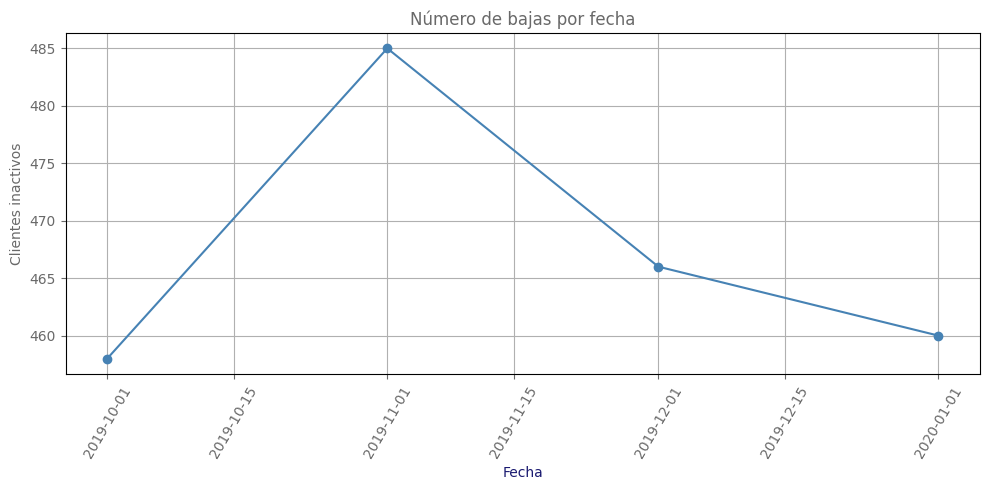

In [46]:
plt.figure(figsize=(10,5))
plt.plot(inactive_clients['end_effective_date'], inactive_clients['inact_client_count'], marker='o', color='steelblue')
plt.title('Número de bajas por fecha', color='dimgray')
plt.xlabel('Fecha', color='midnightblue')
plt.ylabel('Clientes inactivos', color='dimgray')
plt.xticks(rotation=60)
plt.tick_params(axis='x', colors='dimgray')
plt.tick_params(axis='y', colors='dimgray')
plt.grid(True)
plt.tight_layout()
plt.show()


### Hallazgos del análisis temporal de cancelaciones

La visualización de la columna `end_date` permitió identificar el comportamiento de las cancelaciones de clientes a lo largo del tiempo.

Se observa que a inicios de octubre de 2019 se registraban aproximadamente 450 cancelaciones. A lo largo del mes, esta cifra fue en aumento, alcanzando su punto más alto el 1 de noviembre de 2019, con un pico de aproximadamente 485 cancelaciones.

Posteriormente, a partir de esa fecha, las cancelaciones muestran una tendencia descendente constante hasta el cierre del periodo observado (enero de 2020).

Este comportamiento sugiere que pudo haber ocurrido algún evento o condición particular en octubre que motivó un mayor número de cancelaciones, seguido de una estabilización en los meses siguientes.


Con estas acciones, se concluye la etapa de exploración y limpieza. Los datos se encuentran listos para iniciar el preprocesamiento y la construcción de los modelos de clasificación.

# Preprocesamiento de datos.

Como primer paso del preprocesamiento, definiremos la variable objetivo que será utilizada para entrenar nuestro modelo de clasificación.

La columna `end_date` nos indica si un cliente ha cancelado su contrato. Por lo tanto, a partir de esta columna crearemos una nueva variable binaria llamada `exited`, que tomará los siguientes valores:

- `1` si el cliente ha cancelado (es decir, si `end_date` contiene una fecha).
- `0` si el cliente sigue activo (es decir, si `end_date` es nulo o `NaT`).

Esta nueva variable será nuestro objetivo el cual el modelo intentará predecir en función de las características del cliente y los servicios que utiliza.

In [47]:
df_master['exited'] = df_master['end_date'].notnull().astype(int)
print(df_master['exited'])

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: exited, Length: 7043, dtype: int64


Eliminación de columna `end_date`

Una vez creada la variable binaria `exited`, que representa si un cliente canceló o no su contrato, la columna `end_date` deja de ser necesaria para el análisis.

Por lo tanto, se elimina del dataset para evitar redundancia y asegurar que no sea utilizada como variable predictora en el modelo.


In [48]:
df_master = df_master.drop(['end_date'], axis=1)

Para la conversión de todas las columnas categóricas con respuestas tipo "Yes" y "No" a valores binarios, utilizando la siguiente lógica:

"Yes" será reemplazado por 1

"No" será reemplazado por 0

In [49]:
binary_columns = ['paperless_billing','partner','dependents','online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies', 'multiple_lines']

In [50]:
for column in binary_columns:
    df_master[column] = df_master[column].map({'Yes': 1, 'No': 0})

In [51]:
#Validamos la reasignación
df_master[binary_columns].head()

,paperless_billing,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,1,1,0,0,1,0,0,0,0,0
1,0,0,0,1,0,1,0,0,0,0
2,1,0,0,1,1,0,0,0,0,0
3,0,0,0,1,0,1,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0


## Transformación de variables categóricas con one-hot encoding

Algunas columnas del dataset contienen variables categóricas con más de dos categorías, por lo que no pueden ser transformadas con mapeo binario como las variables tipo `"Yes"`/`"No"`. Para hacerlas utilizables por los modelos de machine learning, aplicaremos **codificación one-hot**.

Las columnas seleccionadas para este proceso son:

- `type`: tipo de contrato del cliente  
- `payment_method`: método de pago  
- `gender`: género del cliente  
- `internet_service`: tipo de servicio de Internet

Estas variables serán transformadas en columnas binarias, una por cada categoría distinta, lo que permitirá a los modelos interpretar sus valores correctamente.

Para evitar multicolinealidad en modelos lineales, se aplicará el argumento `drop_first=True`, eliminando una de las categorías de cada variable como referencia.

In [52]:
# Convertir variables categóricas en variables dummy
category_columns = ['type','payment_method','gender','internet_service']
dummies = pd.get_dummies(df_master[category_columns], drop_first=True)

In [53]:
df_master = pd.concat([df_master, dummies], axis=1)
df_master = df_master.drop(category_columns, axis=1) #Eliminamos columnas con strings

## Examen del Equilibrio de Clases
Distribución de clases: Vamos a ver cuántos clientes se han ido (1) y cuántos no (0).

Visualización: Graficaremos la distribución de las clases para tener una visión clara de cuán equilibrada está la variable objetivo.

In [54]:
# Ver la distribución de la clase objetivo 'exited'
class_distribution = df_master['exited'].value_counts(normalize=True)

# Imprimir la distribución
print("Distribución de clases en el target (exited):\n", class_distribution)

Distribución de clases en el target (exited):
 0    0.73463
1    0.26537
Name: exited, dtype: float64


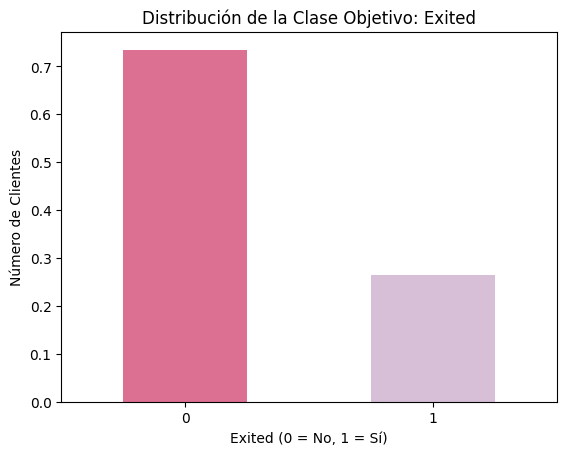

In [55]:
class_distribution.plot(kind='bar', color=['palevioletred','thistle'])
plt.title('Distribución de la Clase Objetivo: Exited')
plt.xlabel('Exited (0 = No, 1 = Sí)')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=0)
plt.show()

Al analizar la distribución de la variable objetivo `exited`, se observa que:

- El 73.5% de los clientes **no cancelaron** su contrato.
- El 26.5% de los clientes **sí cancelaron**.

Aunque no se trata de un desbalance extremo, es una diferencia considerable que podría sesgar los modelos hacia la clase mayoritaria si no se considera adecuadamente.

Por esta razón, se tendrán en cuenta métricas sensibles al desbalance (como AUC-ROC y F1-score) durante la evaluación. También se valorará el uso de técnicas de reequilibrio si el desempeño del modelo lo requiere.


# Plan de trabajo

## Introducción
- Descripción breve del proyecto, tipo de problema y tarea objetivo.

## Exploración de datos
- Carga de archivos.
- Revisar estructura y tipos de datos.
- Identificar valores nulos o inconsistentes.
- Analizar la distribución de la variable objetivo (`EndDate`).

## Limpieza de datos
- Corregir o eliminar valores ausentes.
- Uniformizar categorías y formatos de variables.
- Verificar duplicados y registros inconsistentes.

## Preprocesamiento
- Convertir variables categóricas a numéricas (one-hot encoding u otros).
- Escalar variables numéricas si es necesario.
- Estudiar el balance de clases de la variable objetivo.
- Definir la estrategia si hay desbalance (submuestreo, sobremuestreo, uso de métricas adecuadas).

## Preparación de modelos
- Seleccionar modelos de clasificación.
- Dividir datos en entrenamiento y prueba.

## Entrenamiento de modelos
- Entrenar cada modelo con los datos procesados.
- Ajustar hiperparámetros si es necesario.

## Evaluación de modelos
- Calcular métricas principales:
  - AUC-ROC (métrica principal).
  - Exactitud (métrica adicional).
- Generar curvas ROC para comparación visual.
- Analizar la matriz de confusión (para entender mejor los errores).

## Selección del mejor modelo
- Seleccionar el modelo con mayor AUC-ROC.
- Verificar consistencia con otras métricas.

## Conclusiones e informe
- Resumir los resultados obtenidos.
- Describir el modelo elegido y su rendimiento.
- Recomendar próximos pasos (posibles mejoras, otros datos a recolectar).

